# **`Tweets` Sentiment Analysis and `3` Deep `Neural Networks`**

> A **deep neural network (DNN)** is an **artificial neural network (ANN**) with **multiple layers** between the **input and output layers**.

***

#### **Purpose of this Project**

* In this project, we will Build **Deep Neural Networks** for `Sentiment Analysis`.

![Image](https://www.altexsoft.com/media/2018/09/sentiment_analysis.jpg)

* We will **Build, Train** and **Save 3** different types of **Neural Networks**:  

1. **Multi-Layer Perceptron**
2. **Convolutional Neural Networks** 
3. **Recurrent Neural Networks (LSTM)** 

* We will then **Compare** these models.

***

#### **STEPS**

* [A. Preprocessing Dataset](#1)

* [B. Embedding Layer](#2)

'''

* [C. Deep Neural Networks](#3)
    * [1. Multi-Layer Perceptron](#4)
    * [2. Convolutional Neural Networks](#5)
    * [3. Recurrent Neural Networks (LSTM)](#6)

'''

* [D. Comparing Neural Networks](#7)

***
***

## **A. Preprocessing Dataset** <a id='1'></a>

* We will use this [1 million Tweets](https://www.kaggle.com/datasets/tariqsays/sentiment-dataset-with-1-million-tweets) dataset.
* Download and Extract the Dataset.

***

### **Read-in Dataset**

In [63]:
import pandas as pd

dir = r"D:\Data_Bag\Machine_Learning_Pipelines\NLP\1_million_Tweets_Sentiment_Analysis\dataset.csv"
df = pd.read_csv(dir)

df.head()

,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
1,#BadBunny: Como dos gotas de agua: Joven se di...,es,negative
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious


#### **Cleaning Dataset**

* This dataset has tweets in 3 languages - english **en**, spanish **es** and french **fr**. 
* We will only keep English tweets and remove the rest.

In [ ]:
df = df.loc[(df['Language'] == 'en')]

print(df.Language.unique())
df.head()

['en']


,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
5,It sucks for me since I'm focused on the natur...,en,negative


*** 

### **Sampling Dataset**

* 1 million tweets is a lot to train on.
* We will sample 70,000 tweets for each **Positive, Negative** and **Uncertainity (Neutral)** tweets.

In [ ]:
positive = df[df['Label'] == 'positive'][:70000]
negative = df[df['Label'] == 'negative'][:70000]
uncertainty = df[df['Label'] == 'uncertainty'][:70000]

sample = pd.concat([positive, negative, uncertainty])
print(sample.shape)
sample.head()

(210000, 3)


,Text,Language,Label
3,Rwanda is set to host the headquarters of Unit...,en,positive
12,Wimbledon: Nick Kyrgios admits spitting toward...,en,positive
13,is booktwt a thing? if so thats her and she sp...,en,positive
18,At the end we consume fictional stories to enj...,en,positive
19,#Duranto Express A1 coach AC not working prope...,en,positive


In [ ]:
##Dropping irrelevant Column - Language
#sample = sample.drop(['Language'], axis=1)

print(sample['Label'].value_counts())
sample = sample.to_csv('sample.csv', index=False)

0    70000
1    70000
2    70000
Name: Label, dtype: int64


#### **Creating Labels**

* We have three classes here, we will give them index numbers starting from 0.
* Positive == 0, Negative == 1, Uncertainity == 2.

In [ ]:
##Normalizing Labels
sample.loc[sample["Label"] == "positive", "Label"] = 0
sample.loc[sample["Label"] == "negative", "Label"] = 1
sample.loc[sample["Label"] == "uncertainty", "Label"] = 2

***

### **Text Preprocessing**

* We will preprocess our text to make it more interpretable. We will - 
    * Remove **irrelevant items** such as **Twitter Handles, and URLs**
    * Convert **Emoji, Emoticons and Chat Words** into simple words
    * **Tokenize**
    * **Lemmatize**
* I will use the **tweets_sentiment_analysis** function from this [pipeline](https://www.kaggle.com/code/sanskar551/sentiment-analysis-tweets-preprocessing-pipeline) I created.
* This pipeline also removes **irrelevant stopwords**, but I will **comment out this functionality**.

#### **Importing Pipeline from another folder**

In [ ]:
import sys
sys.path.append(r"C:\Users\Sanskar\AI\Machine_Learning_Pipelines\Natural_Language_Processing\Pipelines")

import text_preprocessing

#### **Read in Sample Data**

In [ ]:
import pandas as pd

sample = pd.read_csv('sample.csv')
sample.head()

,Text,Label,Text_Preprocessed
0,Rwanda is set to host the headquarters of Unit...,0,rwanda be set to host the headquarters of unit...
1,Wimbledon: Nick Kyrgios admits spitting toward...,0,wimbledon nick kyrgios admits spit towards ' d...
2,is booktwt a thing? if so thats her and she sp...,0,be booktwt a thing if so that s she and she sp...
3,At the end we consume fictional stories to enj...,0,at the end we consume fictional story to enjoy...
4,#Duranto Express A1 coach AC not working prope...,0,duranto express a1 coach ac not work properly ...


#### **Applying Pipeline to Dataset**

In [ ]:
sample['Text_Preprocessed'] = sample['Text'].apply(lambda text: text_preprocessing.tweets_sentiment_analysis(text))

sample = sample.to_csv('sample.csv', index=False)

***
***

## **B. Embedding Layer** <a id='2'></a>

* The **Embedding layer** converts our **textual data into numeric data** and is used as the first layer for the **deep learning models** in Keras.
* Let's first do a **Train-Validation split** in our dataset.

### **Importing Libraries**

In [30]:
import pandas as pd
import numpy as np
from numpy import array, asarray, zeros
import re
import nltk
from nltk.corpus import stopwords

import pydot
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras import backend as K
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Conv1D, RNN, LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

### **Read in Data**

In [31]:
sample = pd.read_csv('sample.csv')

### **Train-Test split**

In [32]:
X = sample['Text_Preprocessed']
y = sample['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [33]:
y_train.value_counts()

0    56167
1    55966
2    55867
Name: Label, dtype: int64

***

### **Preparing the Embedding Layer**

* We will use the **Tokenizer** class from the **keras.preprocessing.text** module to create a **word-to-index dictionary**.
* In the **word-to-index dictionary**, each **word** in the corpus is used as a **key**, while a corresponding **unique index** is used as the **value** for the key.

#### **Keras Tokenizer**

In [34]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [35]:
X_train[1]

[11,
 18,
 263,
 28,
 1430,
 42,
 8,
 96,
 26,
 30,
 231,
 1,
 79,
 42,
 9,
 230,
 9,
 1,
 46,
 4,
 93,
 359,
 4,
 39,
 314,
 18,
 263,
 6,
 973,
 8]

#### **Pad Sequence**

* Tweets are usually of varied length.
* Since texts have now been converted into a list of unique word index, we set the maximum size of each list to 100.
* The lists with size greater than 100 will be truncated to 100. For the lists that have length less than 100, we will add 0 at the end of the list until it reaches the max length.

In [36]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#### **Feature Matrix**

* We will use **GloVe embeddings** to create our **feature matrix**.
* Here, we load the **GloVe word embeddings** and create a **dictionary** that will contain **words as keys** and their corresponding **embedding list as values**.

In [37]:
embeddings_dictionary = dict()
glove_file = open(r'D:\Data_Bag\Machine_Learning_Pipelines\NLP\glove_6B_100d\glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

#### **Embedding Matrix**

* Finally, we will create an **embedding matrix** where each **row number** will correspond to the **index of the word** in the corpus. 

* The matrix will have **100 columns** where each **column will contain the GloVe word embeddings** for the **words** in our corpus.

In [38]:
embedding_matrix = zeros((vocab_size, 100))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [39]:
len(embedding_matrix)

109629

***
***

## **C. Deep Neural Networks** <a id='3'></a>

* Here We will - 
    * **Build**, 
    * **Train and Save Best Model**, and
    * **Evaluate** ..... each of the Four **Deep Neural Networks**.

***
***

## **1. Multi-Layer Perceptron** <a id='4'></a>

* A **Multilayer Perceptron (MLP)** is a **Feed Forward Artificial Neural Network** that generates a set of outputs from a set of inputs.
* An **MLP** is characterized by several **layers of input nodes** connected as a directed graph between the **input nodes** connected as a directed graph between the **input and output layers**.
> **MLP** uses **backpropagation** for training the network.

***

### **Model**

In [40]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(3, activation='softmax'))

sgd = keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          10962900  
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1000100   
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 603       
Total params: 12,024,003
Trainable params: 1,061,103
Non-trainable params: 10,962,900
____________________________________

#### **Model Explained**

##### **Sequential API:**
* A framework that is used for creating the **Model** of instances in the **Sequential class**. 
* Since we have only one input **(Text)** and one output **(Labels)**, we will use [keras sequential API](https://keras.io/guides/sequential_model/) to build ur model.

##### **Embedding Layer:**
* This layer turns **positive integers (indexes)** into **dense vectors of fixed size**.
* The **vocab_size** means size of the vocabulary, i.e. **max integer index +1**.
* The **100** represents dimension of **dense embeddings**.
* We will use the **embedding matrix** we created as **embeddings initializer**.
* The **input_length** injects Embeddings into connected layers which is set to **maxlen** i.e. **max length of  the token list** which is 100.
* **trainable** is set to **False** as we only wish to **create embeddings** on this layer **not train** it.

##### **Model Architecture:**
**Embedding Layer:** 
* Firstly, we add our **Embedding Layer** to create our **embedding**.

**Flatten Layer:** 
* Secondly, we add **Flatten** layer.  
* A **Flatten layer** in Keras **reshapes the tensor** to have a shape that is **equal to the number of elements** contained in the **tensor**. 
* This is the same thing as **making a 1d-array of elements**. 
* Without this, the shape of the dense outputs cannot be computed.

**Hidden Dense Layer:** 
* Dense layer is the layer that contains all the neurons that are deeply connected within themselves.
* These dense layers learn from the data.
* **100, 200** show the number of **neurons** in each **layer**
* The **activation function decides** whether a **neuron** should be **activated or not** by calculating the **weighted sum** and further **adding bias** to it.
* The **relu activation** stands for **Rectified linear unit**. It is **non-linear**, which means we can easily **backpropagate the errors** and have **multiple layers of neurons** being activated by the ReLU function.
* **Relu** value range is **[0, inf)**.

**Output Layer:**
* This layer is also a **Dense layer** with **3** neurons.
* This layer has an activation function of **softmax**, as softmax is used to handle **mulitple-classes**.

#### **Learning Rate**

* We set our **learning rate** using **keras optimizer SGD** as **0.01**.

##### **Compiling Model:**

**Optimizers**
* Optimizers are algorithms or methods used to change the attributes of the neural network such as weights and learning rate to reduce the losses.
* **sgd** means **Schocastic Gradient Descent**, which basically means we enable our model for **back-propogation**.

**Loss**
* These functions tell us how much the predicted output of the model differs from the actual output.
* We use **sparse_categorical_crossentropy** as we have our **y** is available as **Multi-class Labels**.

**Metrics**
* Keras allows you to list the metrics to monitor during the training of your model.
* We use **Accuracy (acc)** in our model as metrics.

***

#### **Train and Save Best Model**

We will pass some **callbacks** into training of our model.

* **ReduceLROnPlateau:** This callback **reduces learning rate** if the **monitored** (validation loss given in this case) hits **stops changing**.

* **Early Stopping:** This callback **stops the training** when the given value (validation loss here) stops improving.

* **ModelCheckpoint:** This callback **saves the weights and biases** of the **best model** to the given **file path**. It monitors validation accuracy to do so.

We will then train our model for **70 epochs**, a **batch size of 32** and a **validation split of 20 percent**.

In [41]:
filepath = r'C:\Users\Sanskar\AI\Machine_Learning_Pipelines\Natural_Language_Processing\Models\best_mpl_model.hdf5'

my_callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5),
    keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=11),
    keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_acc', mode='max', save_best_only=True)
]

history = model.fit(X_train, y_train, batch_size=32, epochs=70, verbose=1, validation_split=0.2, callbacks=my_callbacks)

Epoch 1/70


c:\Users\Sanskar\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\data_adapter.py:1505: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


4200/4200 [==============================] - 7s 2ms/step - loss: 0.8138 - acc: 0.6209 - val_loss: 0.6771 - val_acc: 0.7062
Epoch 2/70
4200/4200 [==============================] - 7s 2ms/step - loss: 0.6603 - acc: 0.7121 - val_loss: 0.6671 - val_acc: 0.7050
Epoch 3/70
4200/4200 [==============================] - 6s 1ms/step - loss: 0.6181 - acc: 0.7334 - val_loss: 0.6495 - val_acc: 0.7171
Epoch 4/70
4200/4200 [==============================] - 6s 2ms/step - loss: 0.5872 - acc: 0.7493 - val_loss: 0.6434 - val_acc: 0.7225
Epoch 5/70
4200/4200 [==============================] - 6s 1ms/step - loss: 0.5556 - acc: 0.7655 - val_loss: 0.6266 - val_acc: 0.7293
Epoch 6/70
4200/4200 [==============================] - 6s 1ms/step - loss: 0.5231 - acc: 0.7812 - val_loss: 0.6296 - val_acc: 0.7329
Epoch 7/70
4200/4200 [==============================] - 6s 1ms/step - loss: 0.4869 - acc: 0.7988 - val_loss: 0.5986 - val_acc: 0.7472
Epoch 8/70
4200/4200 [==============================] - 6s 1ms/step - los

***

#### **Evaluating Model**

In [42]:
score = model.evaluate(X_test, y_test, verbose=1)

1313/1313 [==============================] - 2s 1ms/step - loss: 1.0239 - acc: 0.7526


In [43]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 1.0238629579544067
Test Accuracy: 0.7526190280914307


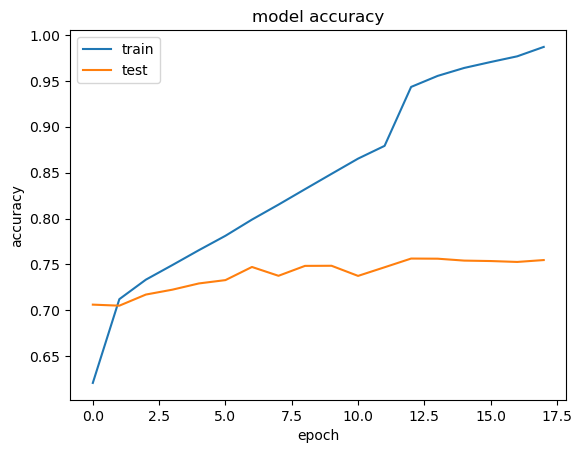

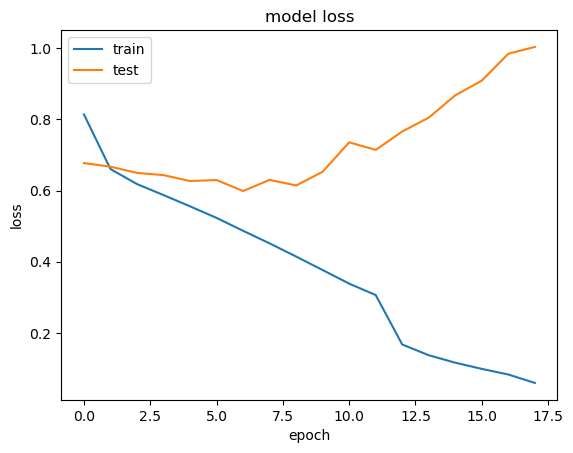

In [44]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#### **Clear Model**

In [45]:
keras.backend.clear_session()

***
***

## **2. Convolutional Neural Network** <a id='5'></a>

* **Convolutional neural network** is a type of network that is primarily used for **2D data classification**, such as images.
* **Convolutional neural networks** have been found to **work well** with **text dat**a as well.
* We can use **1D convolutional neural networks** to extract features from our data.

#### **Model**

In [46]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(3, activation='softmax'))

sgd = keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          10962900  
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 256)           164096    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 88, 256)           327936    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 11,519,831
Trainable params: 556,931
Non-trainable params: 10,962,900
______________________________________

#### **Model Explained**

The only difference here is in the **Hidden Layers** of the **Model Architecture**.

* **Conv1D** are **1 dimensional Convolutional Neural Network.**
* **Filters** are the **dimensionality** of the **output space** (i.e. the number of output filters in the convolution).
* **Kernel Size** is an **integer or tuple/list** of a **single integer**, specifying the **length of the 1D convolution window**.
* The **relu activation** stands for **Rectified linear unit**. It is **non-linear**, which means we can easily **backpropagate the errors** and have **multiple layers of neurons** being activated by the ReLU function.
* **Relu** value range is **[0, inf)**.

***

#### **Train and Save Model**

* We will use same callbacks and Hyperparameters.
* We will change filepath to - best_cnn_model.hdf5

In [47]:
filepath = r'C:\Users\Sanskar\AI\Machine_Learning_Pipelines\Natural_Language_Processing\Models\best_cnn_model.hdf5'

my_callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5),
    keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=11),
    keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_acc', mode='max', save_best_only=True)
]

history = model.fit(X_train, y_train, batch_size=32, epochs=70, verbose=1, validation_split=0.2, callbacks=my_callbacks)

Epoch 1/70


c:\Users\Sanskar\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\data_adapter.py:1505: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


4200/4200 [==============================] - 12s 2ms/step - loss: 0.6213 - acc: 0.7296 - val_loss: 0.3462 - val_acc: 0.8734
Epoch 2/70
4200/4200 [==============================] - 9s 2ms/step - loss: 0.2194 - acc: 0.9209 - val_loss: 0.1595 - val_acc: 0.9424
Epoch 3/70
4200/4200 [==============================] - 9s 2ms/step - loss: 0.1282 - acc: 0.9524 - val_loss: 0.1247 - val_acc: 0.9547
Epoch 4/70
4200/4200 [==============================] - 9s 2ms/step - loss: 0.1035 - acc: 0.9601 - val_loss: 0.1036 - val_acc: 0.9589
Epoch 5/70
4200/4200 [==============================] - 9s 2ms/step - loss: 0.0919 - acc: 0.9639 - val_loss: 0.1000 - val_acc: 0.9605
Epoch 6/70
4200/4200 [==============================] - 9s 2ms/step - loss: 0.0839 - acc: 0.9669 - val_loss: 0.0984 - val_acc: 0.9602
Epoch 7/70
4200/4200 [==============================] - 9s 2ms/step - loss: 0.0772 - acc: 0.9701 - val_loss: 0.0992 - val_acc: 0.9604
Epoch 8/70
4200/4200 [==============================] - 9s 2ms/step - lo

***

#### **Evaluating Model**

In [48]:
score = model.evaluate(X_test, y_test, verbose=1)

1313/1313 [==============================] - 2s 2ms/step - loss: 0.1055 - acc: 0.9610


In [49]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.10549582540988922
Test Accuracy: 0.9610475897789001


* **CNN** model shows an accuracy of **95 percent** whereas **MPL** model showed **75 percent** accuracy.
* That's a big improvement.

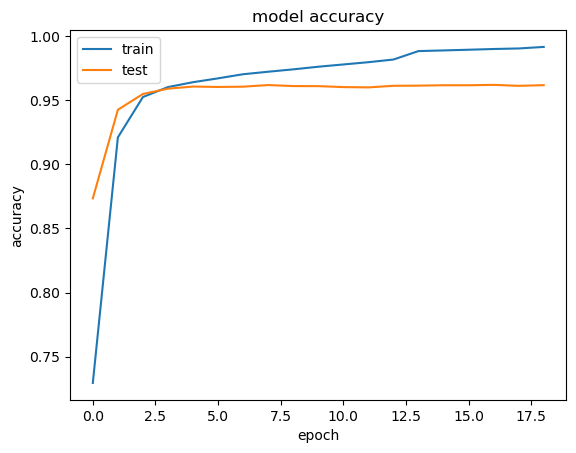

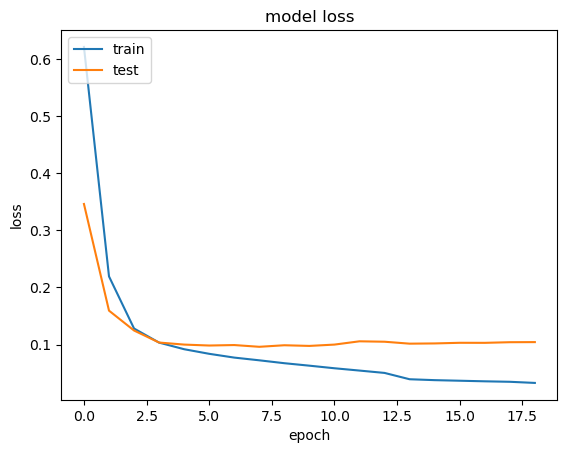

In [50]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#### **Clear Model**

In [51]:
keras.backend.clear_session()

***
***

## **3. Recurrent Neural Network (LSTM)** <a id='6'></a>

* **Recurrent neural network** is a type of **neural networks** that is proven to work well with **sequence data**. 
* Since **text** is actually a **sequence of words**, a recurrent neural network is an automatic choice to solve text-related problems.
* Here, we will use an **LSTM (Long Short Term Memory network)** which is a variant of **RNN**.

#### **Model**

In [52]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

model.add(embedding_layer)
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(256))
model.add(Dense(3, activation='softmax'))

sgd = keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          10962900  
_________________________________________________________________
lstm (LSTM)                  (None, 100, 128)          117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 256)          394240    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 12,000,471
Trainable params: 1,037,571
Non-trainable params: 10,962,900
_________________________________________________________________
None


#### **Model Explained**

Here too, everything will be same except the **Hidden Layers** in the **Model Architecture.**

* **LSTM** layers are used with **128 & 256** neurons.
* **Activation** is default to **tanh** when used in [keras](https://keras.io/)
* **return_sequence=True** returns **full sequence** for next layer.

***

#### **Train and Save Model**

* We will use same callbacks and Hyperparameters.
* We will change filepath to - best_lstm_model.hdf5

In [53]:
filepath = r'C:\Users\Sanskar\AI\Machine_Learning_Pipelines\Natural_Language_Processing\Models\best_lstm_model.hdf5'

my_callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5),
    keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=11),
    keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_acc', mode='max', save_best_only=True)
]

history = model.fit(X_train, y_train, batch_size=32, epochs=70, verbose=1, validation_split=0.2, callbacks=my_callbacks)

Epoch 1/70


c:\Users\Sanskar\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\data_adapter.py:1505: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


4200/4200 [==============================] - 95s 22ms/step - loss: 1.0988 - acc: 0.3330 - val_loss: 1.0988 - val_acc: 0.3346
Epoch 2/70
4200/4200 [==============================] - 92s 22ms/step - loss: 1.0988 - acc: 0.3333 - val_loss: 1.0987 - val_acc: 0.3336
Epoch 3/70
4200/4200 [==============================] - 91s 22ms/step - loss: 1.0988 - acc: 0.3331 - val_loss: 1.0989 - val_acc: 0.3335
Epoch 4/70
4200/4200 [==============================] - 93s 22ms/step - loss: 1.0988 - acc: 0.3319 - val_loss: 1.0986 - val_acc: 0.3346
Epoch 5/70
4200/4200 [==============================] - 94s 22ms/step - loss: 1.0988 - acc: 0.3345 - val_loss: 1.0993 - val_acc: 0.3320
Epoch 6/70
4200/4200 [==============================] - 94s 22ms/step - loss: 1.0988 - acc: 0.3340 - val_loss: 1.0987 - val_acc: 0.3346
Epoch 7/70
4200/4200 [==============================] - 94s 22ms/step - loss: 1.0988 - acc: 0.3320 - val_loss: 1.0986 - val_acc: 0.3346
Epoch 8/70
4200/4200 [==============================] - 95s

***

#### **Evaluating Model**

In [54]:
score = model.evaluate(X_test, y_test, verbose=1)

1313/1313 [==============================] - 17s 12ms/step - loss: 0.0879 - acc: 0.9649


In [55]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.08788356184959412
Test Accuracy: 0.9648809432983398


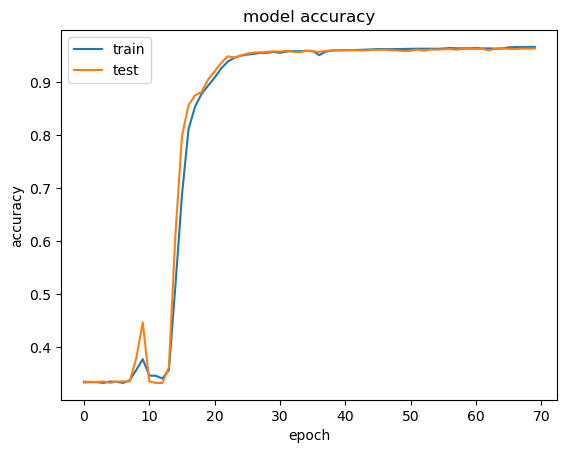

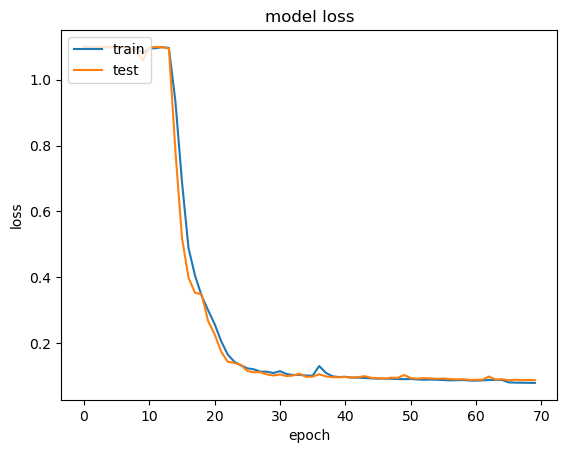

In [56]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#### **Clear Model**

In [57]:
keras.backend.clear_session()

***
***

## **D. Comparing Neural Networks** <a id='7'></a>

* We will Load and Test each of the models.

> **NOTE:** The **results** here may **defer** from the **Evaluation results** as we will be **loading the best model saved** instead of the **current trained model** as before.

#### **Loading Model**

In [59]:
mpl_model = load_model(r'C:\Users\Sanskar\AI\Machine_Learning_Pipelines\Natural_Language_Processing\Models\best_mpl_model.hdf5')
cnn_model = load_model(r'C:\Users\Sanskar\AI\Machine_Learning_Pipelines\Natural_Language_Processing\Models\best_cnn_model.hdf5')
lstm_model = load_model(r'C:\Users\Sanskar\AI\Machine_Learning_Pipelines\Natural_Language_Processing\Models\best_lstm_model.hdf5')

#### **Testing Model**

In [60]:
mpl_score = mpl_model.evaluate(X_test, y_test, verbose=1)
cnn_score = cnn_model.evaluate(X_test, y_test, verbose=1)
lstm_score = lstm_model.evaluate(X_test, y_test, verbose=1)

1313/1313 [==============================] - 17s 12ms/step - loss: 0.0909 - acc: 0.9640


#### **Score**

In [61]:
print("MPL Score:", mpl_score[0])
print("CNN Score:", cnn_score[0])
print("LSTM Score:", lstm_score[0])

MPL Score: 0.7768096923828125
CNN Score: 0.10450059175491333
LSTM Score: 0.09086348116397858


#### **Accuracy**

In [62]:
print("MPL Accuracy:", mpl_score[1])
print("CNN Accuracy:", cnn_score[1])
print("LSTM Accuracy:", lstm_score[1])

MPL Accuracy: 0.7540000081062317
CNN Accuracy: 0.9605476260185242
LSTM Accuracy: 0.9640238285064697


* **CNN** and **LSTM** seem to be the best models here with **LSTM** being slightly better.
* But **LSTM** **converges** better than **CNN** and is less likely to **overfit**.

***
***